In [ ]:
# Improved Customer Review Clustering for Marketing Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load your data
data = pd.read_csv("amazon_review_cleaned.csv")

In [ ]:
print(f"Original data shape: {data.shape}")

Original data shape: (843, 19)


In [ ]:
# Enhanced feature engineering
def create_enhanced_features(df):

    # Make a copy to avoid warnings
    df = df.copy()

    # Basic review characteristics
    df['review_length'] = df['reviews.text'].str.len()
    df['word_count'] = df['reviews.text'].str.split().str.len()

    # Rating-based features
    df['rating_deviation'] = df['reviews.rating'] - df['reviews.rating'].median()
    df['is_extreme_rating'] = ((df['reviews.rating'] <= 2) | (df['reviews.rating'] >= 5)).astype(int)
    df['is_high_rating'] = (df['reviews.rating'] >= 4).astype(int)
    df['is_low_rating'] = (df['reviews.rating'] <= 2).astype(int)

    # Helpfulness features
    df['helpfulness_ratio'] = df['reviews.numHelpful'] / (df['reviews.numHelpful'].max() + 1)
    df['is_helpful'] = (df['reviews.numHelpful'] > df['reviews.numHelpful'].median()).astype(int)
    df['helpfulness_per_char'] = df['reviews.numHelpful'] / (df['review_length'] + 1)

    # Review engagement features
    df['words_per_rating'] = df['word_count'] / df['reviews.rating']
    df['engagement_score'] = df['reviews.numHelpful'] * df['reviews.rating']

    # Product-based features
    df['product_category'] = pd.Categorical(df['name']).codes
    df['brand_category'] = pd.Categorical(df['brand']).codes

    # Time-based features
    if 'reviews.date' in df.columns:
        df['reviews.date'] = pd.to_datetime(df['reviews.date'], errors='coerce')
        df['review_year'] = df['reviews.date'].dt.year
        df['review_month'] = df['reviews.date'].dt.month
        df['days_since_min'] = (df['reviews.date'] - df['reviews.date'].min()).dt.days

    # Text length categories
    df['review_length_category'] = pd.cut(df['review_length'],
                                        bins=[0, 100, 300, 1000, float('inf')],
                                        labels=['Short', 'Medium', 'Long', 'Very_Long'])
    df['review_length_cat_code'] = pd.Categorical(df['review_length_category']).codes

    # Word density features
    df['words_per_char'] = df['word_count'] / (df['review_length'] + 1)

    return df


In [ ]:
# Create enhanced features
print("Creating enhanced features...")
data_enhanced = create_enhanced_features(data)

Creating enhanced features...


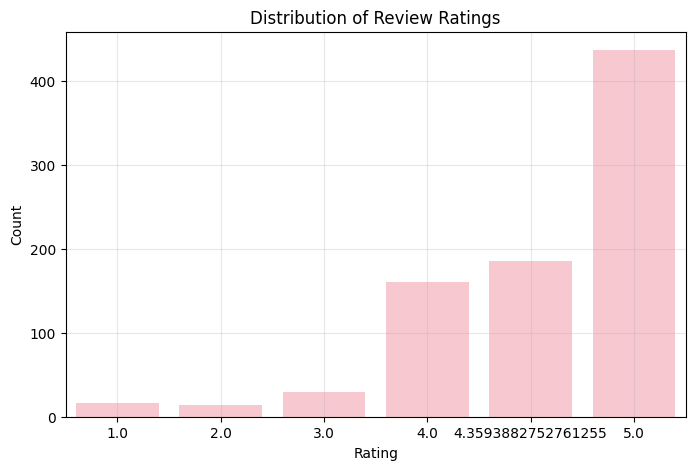

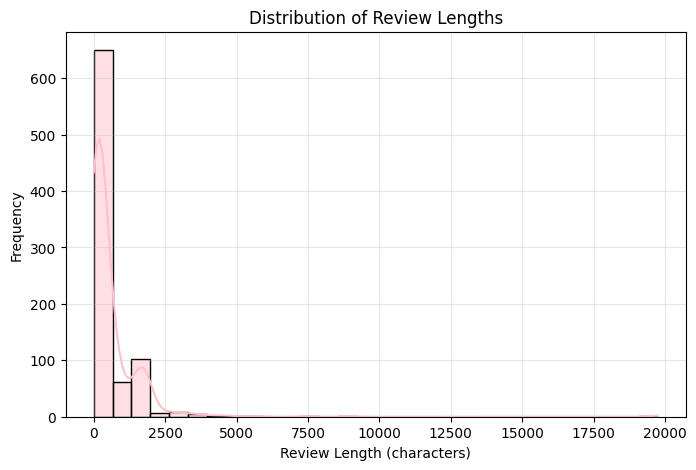

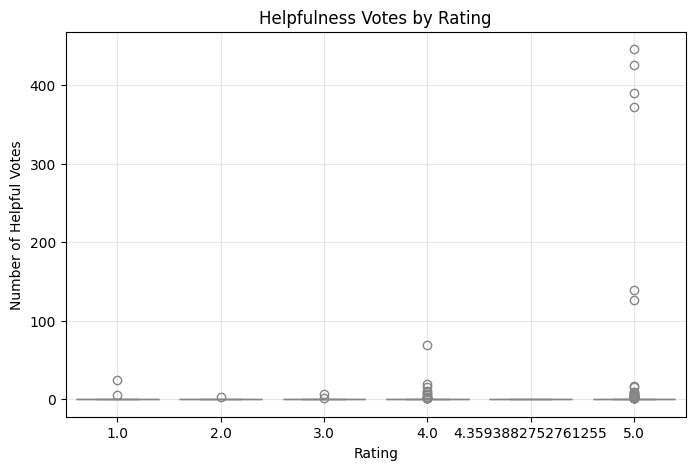

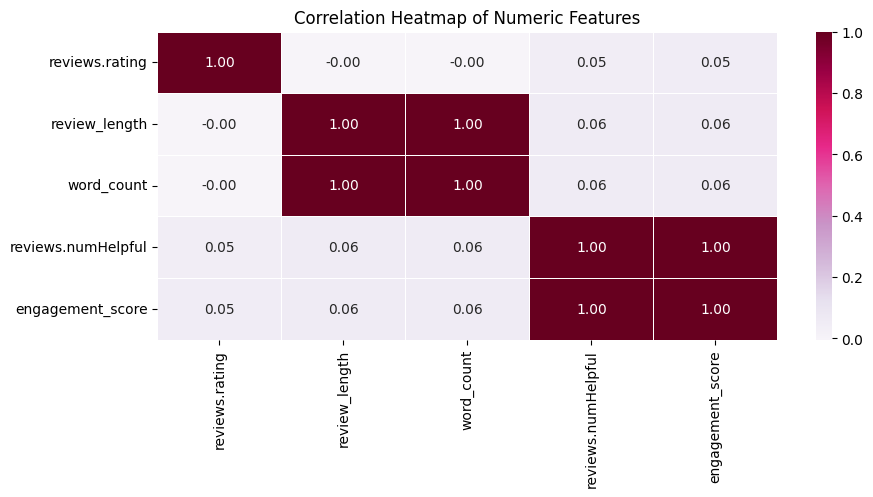

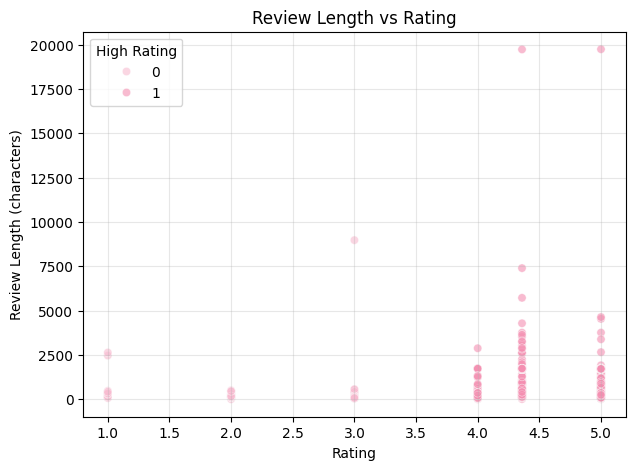

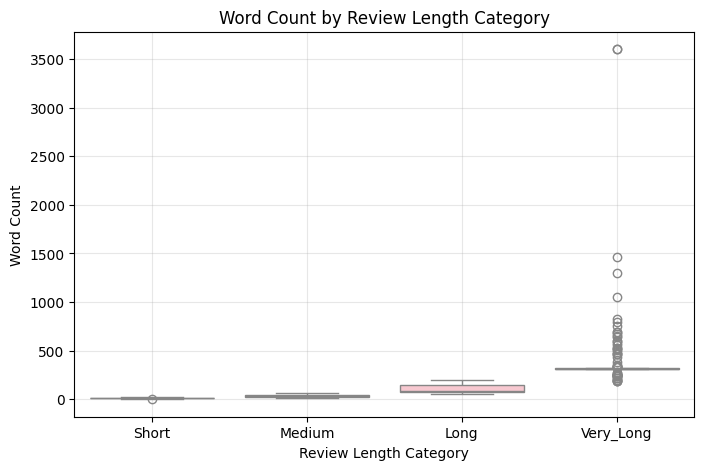

In [ ]:
# EDA

# 1. Rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='reviews.rating', data=data_enhanced, color='pink')
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Review Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data_enhanced['review_length'], bins=30, kde=True, color='pink')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# 3. Review Helpfulness vs Rating
plt.figure(figsize=(8, 5))
sns.boxplot(x='reviews.rating', y='reviews.numHelpful', data=data_enhanced, color='pink')
plt.title("Helpfulness Votes by Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Helpful Votes")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(10, 4))
corr = data_enhanced[['reviews.rating', 'review_length', 'word_count', 'reviews.numHelpful', 'engagement_score']].corr()
sns.heatmap(corr, annot=True, cmap='PuRd', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## 5. Rating vs Review Length Scatter
plt.figure(figsize=(7, 5))
sns.scatterplot(x='reviews.rating', y='review_length', data=data_enhanced, hue='is_high_rating', color='pink', alpha=0.6)
plt.title("Review Length vs Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length (characters)")
plt.legend(title='High Rating')
plt.grid(True, alpha=0.3)
plt.show()

# 6. Boxplot of Review Word Count by Length Category
plt.figure(figsize=(8, 5))
sns.boxplot(x='review_length_category', y='word_count', data=data_enhanced, color='pink')
plt.title("Word Count by Review Length Category")
plt.xlabel("Review Length Category")
plt.ylabel("Word Count")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Select features for clustering
feature_columns = [
    'reviews.rating', 'reviews.numHelpful', 'review_length', 'word_count',
    'rating_deviation', 'is_extreme_rating', 'is_high_rating', 'is_low_rating',
    'helpfulness_ratio', 'is_helpful', 'helpfulness_per_char',
    'words_per_rating', 'engagement_score', 'product_category', 'brand_category',
    'review_length_cat_code', 'words_per_char'
]

In [ ]:
# Add time features if available
if 'review_year' in data_enhanced.columns:
    feature_columns.extend(['review_year', 'review_month', 'days_since_min'])


In [ ]:
# Prepare features matrix
X = data_enhanced[feature_columns].fillna(0)
print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_columns}")

Feature matrix shape: (843, 20)
Features used: ['reviews.rating', 'reviews.numHelpful', 'review_length', 'word_count', 'rating_deviation', 'is_extreme_rating', 'is_high_rating', 'is_low_rating', 'helpfulness_ratio', 'is_helpful', 'helpfulness_per_char', 'words_per_rating', 'engagement_score', 'product_category', 'brand_category', 'review_length_cat_code', 'words_per_char', 'review_year', 'review_month', 'days_since_min']


In [ ]:
# Scale features for better clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Find optimal number of clusters
def find_optimal_clusters(X, max_k=15):
    """Find optimal number of clusters using multiple metrics"""
    K = range(2, max_k + 1)
    silhouette_scores = []
    calinski_scores = []
    inertias = []

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        inertias.append(kmeans.inertia_)

    return K, silhouette_scores, calinski_scores, inertias


In [ ]:
print("Finding optimal number of clusters...")
K, sil_scores, cal_scores, inertias = find_optimal_clusters(X_scaled)

Finding optimal number of clusters...


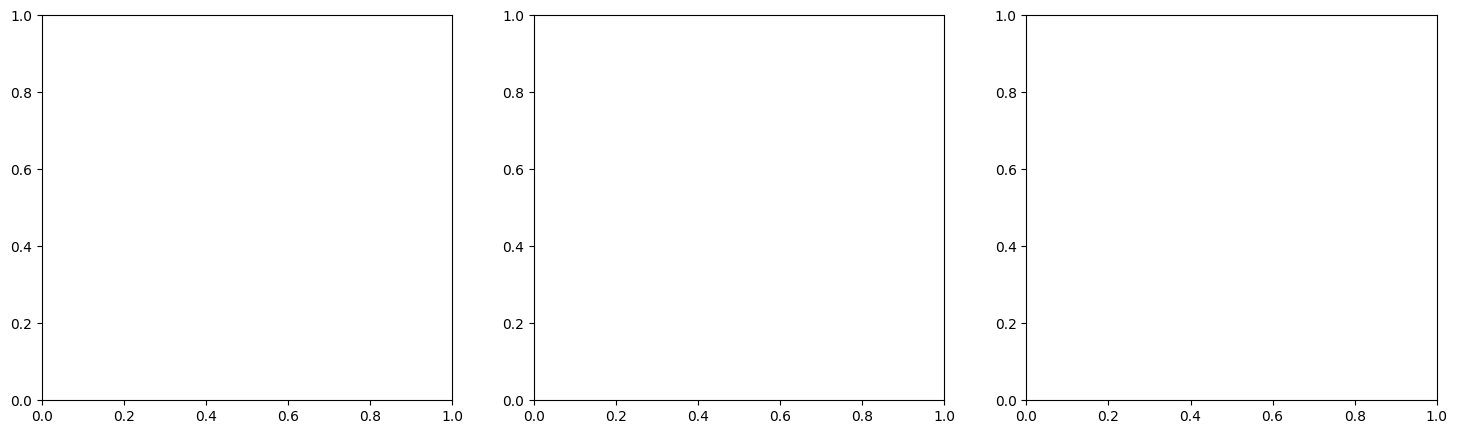

In [ ]:
# Plot clustering metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

In [ ]:
# Silhouette score
axes[0].plot(K, sil_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs Number of Clusters')
axes[0].grid(True, alpha=0.3)
best_sil_k = K[np.argmax(sil_scores)]
axes[0].axvline(x=best_sil_k, color='red', linestyle='--', alpha=0.7)
axes[0].text(best_sil_k, max(sil_scores), f'Best k={best_sil_k}', ha='center')

Text(9, 0.39800752431337577, 'Best k=9')

In [ ]:
# Calinski-Harabasz score
axes[1].plot(K, cal_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title('Calinski-Harabasz Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

In [ ]:
# Elbow method
axes[2].plot(K, inertias, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Inertia')
axes[2].set_title('Elbow Method For Optimal k')
axes[2].grid(True, alpha=0.3)


In [ ]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:
# Choose optimal k
optimal_k = best_sil_k
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(sil_scores):.3f}")


Optimal number of clusters: 9
Best silhouette score: 0.398


In [ ]:
# Perform clustering with optimal k
print(f"Performing K-means clustering with k={optimal_k}...")
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

Performing K-means clustering with k=9...


In [ ]:
# Add cluster labels to dataframe
data_enhanced['cluster'] = cluster_labels

In [ ]:
print(f"Final Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"Final Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, cluster_labels):.3f}")


Final Silhouette Score: 0.398
Final Calinski-Harabasz Score: 283.661


In [ ]:
# Analyze clusters for marketing insights
def analyze_clusters_marketing(df):
    """Analyze clusters for marketing insights without NLP"""


    print("------ CUSTOMER SEGMENT ANALYSIS FOR MARKETING ------")

    cluster_summary = []

    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_data)

        print(f"\n--- CLUSTER {cluster_id}: {cluster_size} customers ({cluster_size/len(df)*100:.1f}%) ---")

        # Rating and satisfaction analysis
        avg_rating = cluster_data['reviews.rating'].mean()
        rating_std = cluster_data['reviews.rating'].std()
        high_rating_pct = (cluster_data['reviews.rating'] >= 4).mean() * 100
        low_rating_pct = (cluster_data['reviews.rating'] <= 2).mean() * 100

        print(f"SATISFACTION METRICS:")
        print(f"  Average Rating: {avg_rating:.2f} ± {rating_std:.2f}")
        print(f"  High Ratings (4-5): {high_rating_pct:.1f}%")
        print(f"  Low Ratings (1-2): {low_rating_pct:.1f}%")

        # Engagement analysis
        avg_helpfulness = cluster_data['reviews.numHelpful'].mean()
        avg_review_length = cluster_data['review_length'].mean()
        avg_word_count = cluster_data['word_count'].mean()

        print(f"ENGAGEMENT METRICS:")
        print(f"   Average Helpfulness: {avg_helpfulness:.1f}")
        print(f"   Average Review Length: {avg_review_length:.0f} characters")
        print(f"   Average Word Count: {avg_word_count:.0f} words")

        # Product preferences
        top_products = cluster_data['name'].value_counts().head(3)
        print(f" TOP PRODUCTS:")
        for i, (product, count) in enumerate(top_products.items(), 1):
            pct = count / cluster_size * 100
            print(f"   {i}. {product}: {count} reviews ({pct:.1f}%)")

        # Customer behavior classification
        if avg_rating >= 4.5 and high_rating_pct >= 70:
            segment_type = "BRAND ADVOCATES"
            marketing_focus = " Leverage for testimonials, referrals, premium products"
        elif avg_rating >= 3.5 and low_rating_pct <= 20:
            segment_type = "SATISFIED CUSTOMERS"
            marketing_focus = " Upsell opportunities, loyalty programs"
        elif avg_rating < 3.0 or low_rating_pct >= 40:
            segment_type = "AT-RISK CUSTOMERS"
            marketing_focus = " Customer service priority, retention campaigns"
        else:
            segment_type = "NEUTRAL CUSTOMERS"
            marketing_focus = " Engagement campaigns, feedback collection"

        print(f" SEGMENT TYPE: {segment_type}")
        print(f" MARKETING FOCUS: {marketing_focus}")

        # Engagement level
        if avg_helpfulness > df['reviews.numHelpful'].median():
            engagement_level = "High Engagement"
        else:
            engagement_level = "Low Engagement"

        if avg_review_length > df['review_length'].median():
            review_style = "Detailed Reviewers"
        else:
            review_style = "Brief Reviewers"

        print(f" ENGAGEMENT: {engagement_level}, {review_style}")

        # Store summary for comparison
        cluster_summary.append({
            'cluster': cluster_id,
            'size': cluster_size,
            'avg_rating': avg_rating,
            'high_rating_pct': high_rating_pct,
            'avg_helpfulness': avg_helpfulness,
            'segment_type': segment_type,
            'top_product': top_products.index[0] if len(top_products) > 0 else 'N/A'
        })

    return pd.DataFrame(cluster_summary)


In [ ]:
# Add cluster labels to dataframe
data_enhanced['cluster'] = cluster_labels

# Perform cluster analysis
cluster_summary_df = analyze_clusters_marketing(data_enhanced)

------ CUSTOMER SEGMENT ANALYSIS FOR MARKETING ------

--- CLUSTER 0: 260 customers (30.8%) ---
SATISFACTION METRICS:
  Average Rating: 4.47 ± 0.31
  High Ratings (4-5): 99.6%
  Low Ratings (1-2): 0.0%
ENGAGEMENT METRICS:
   Average Helpfulness: 0.0
   Average Review Length: 1235 characters
   Average Word Count: 227 words
 TOP PRODUCTS:
   1. Amazon Fire TV: 144 reviews (55.4%)
   2. Amazon Premium Headphones: 71 reviews (27.3%)
   3. Certified Refurbished Amazon Fire TV (Previous Generation - 1st): 26 reviews (10.0%)
 SEGMENT TYPE: SATISFIED CUSTOMERS
 MARKETING FOCUS:  Upsell opportunities, loyalty programs
 ENGAGEMENT: Low Engagement, Detailed Reviewers

--- CLUSTER 1: 336 customers (39.9%) ---
SATISFACTION METRICS:
  Average Rating: 5.00 ± 0.00
  High Ratings (4-5): 100.0%
  Low Ratings (1-2): 0.0%
ENGAGEMENT METRICS:
   Average Helpfulness: 0.0
   Average Review Length: 162 characters
   Average Word Count: 31 words
 TOP PRODUCTS:
   1. Amazon Tap - Alexa-Enabled Portable Bluetoo

In [ ]:
# Create visualizations
print("\nCreating visualizations...")


Creating visualizations...


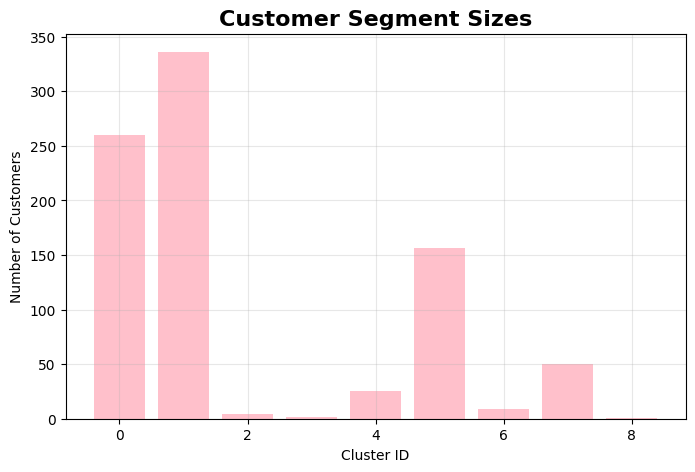

In [ ]:
# 1. Cluster size distribution
plt.figure(figsize=(8, 5))
cluster_counts = data_enhanced['cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index, cluster_counts.values,
               color='pink')
plt.title('Customer Segment Sizes', fontsize=16, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)

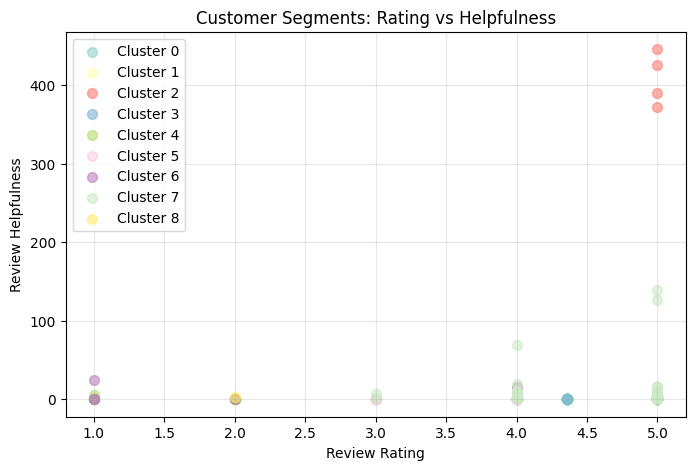

In [ ]:
# 2. Rating vs Helpfulness by cluster
plt.figure(figsize=(8, 5))
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for i, cluster_id in enumerate(sorted(data_enhanced['cluster'].unique())):
    cluster_data = data_enhanced[data_enhanced['cluster'] == cluster_id]
    plt.scatter(cluster_data['reviews.rating'], cluster_data['reviews.numHelpful'],
               alpha=0.6, label=f'Cluster {cluster_id}', color=colors[i], s=50)

plt.xlabel('Review Rating')
plt.ylabel('Review Helpfulness')
plt.title('Customer Segments: Rating vs Helpfulness')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

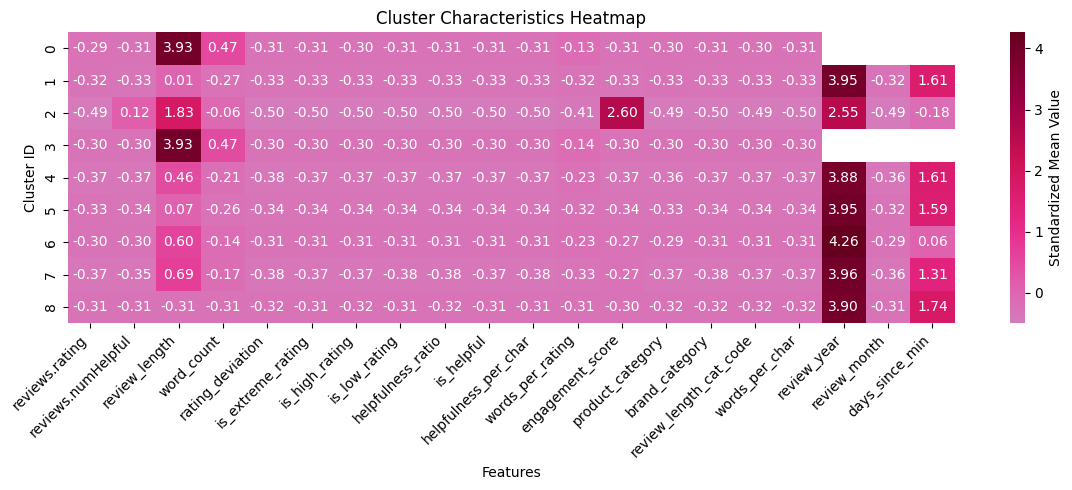

In [ ]:
# 3. Feature importance heatmap
plt.figure(figsize=(12, 5))
cluster_means = data_enhanced.groupby('cluster')[feature_columns].mean()
cluster_means_scaled = pd.DataFrame(scaler.fit_transform(cluster_means.T).T,
                                  columns=feature_columns,
                                  index=cluster_means.index)

sns.heatmap(cluster_means_scaled, annot=True, cmap='PuRd', center=0,
            fmt='.2f', cbar_kws={'label': 'Standardized Mean Value'})
plt.title('Cluster Characteristics Heatmap')
plt.ylabel('Cluster ID')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Marketing strategy recommendations
def generate_marketing_strategies(summary_df):
    """Generate specific marketing strategies for each segment"""


    print("-----TARGETED MARKETING STRATEGIES-----")


    for _, row in summary_df.iterrows():
        cluster_id = row['cluster']
        size = row['size']
        avg_rating = row['avg_rating']
        high_rating_pct = row['high_rating_pct']

        print(f"\nCLUSTER {cluster_id} STRATEGY ({size} customers):")

        if avg_rating >= 4.5:
            print("ADVOCACY PROGRAM:")
            print("   1.Recruit for customer testimonials")
            print("   2.Implement referral rewards")
            print("   3.Offer early access to new products")
            print("   4.Create VIP customer tier")

        elif avg_rating >= 3.5:
            print("GROWTH PROGRAM:")
            print("   1.Send satisfaction surveys")
            print("   2.Offer product recommendations")
            print("   3.Implement loyalty points system")
            print("   4.Cross-sell complementary products")

        else:
            print("RETENTION PROGRAM:")
            print("   1.Proactive customer service outreach")
            print("   2.Offer discounts")
            print("   3.Collect detailed feedback")


        print(f" Focus Product: {row['top_product']}")
        print(f"Campaign Priority: {'High' if size > summary_df['size'].median() else 'Medium'}")

generate_marketing_strategies(cluster_summary_df)

-----TARGETED MARKETING STRATEGIES-----

CLUSTER 0 STRATEGY (260 customers):
GROWTH PROGRAM:
   1.Send satisfaction surveys
   2.Offer product recommendations
   3.Implement loyalty points system
   4.Cross-sell complementary products
 Focus Product: Amazon Fire TV
Campaign Priority: High

CLUSTER 1 STRATEGY (336 customers):
ADVOCACY PROGRAM:
   1.Recruit for customer testimonials
   2.Implement referral rewards
   3.Offer early access to new products
   4.Create VIP customer tier
 Focus Product: Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker
Campaign Priority: High

CLUSTER 2 STRATEGY (4 customers):
ADVOCACY PROGRAM:
   1.Recruit for customer testimonials
   2.Implement referral rewards
   3.Offer early access to new products
   4.Create VIP customer tier
 Focus Product: Amazon Premium Headphones
Campaign Priority: Medium

CLUSTER 3 STRATEGY (2 customers):
ADVOCACY PROGRAM:
   1.Recruit for customer testimonials
   2.Implement referral rewards
   3.Offer early access to new pro

In [ ]:
# Export detailed results
export_columns = ['name', 'reviews.rating', 'reviews.numHelpful', 'review_length',
                 'word_count', 'cluster'] + feature_columns
data_enhanced[export_columns].to_csv('enhanced_clustering_results.csv', index=False)

In [ ]:
cluster_summary_df.to_csv('cluster_marketing_summary.csv', index=False)

In [ ]:
print(f" CLUSTERING ANALYSIS COMPLETE!")

 CLUSTERING ANALYSIS COMPLETE!


In [ ]:
print(f" Created {optimal_k} customer segments for targeted marketing!")

 Created 9 customer segments for targeted marketing!
